### Анализ данных

In [1]:
import pandas as pd

df = pd.read_csv('data/backfin_train.csv')
print(df.nunique())
df.head()

image            41574
species             27
individual_id    13837
dtype: int64


,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


/tmp/ipykernel_73823/1790574273.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(plot.get_yticks(), size=15)


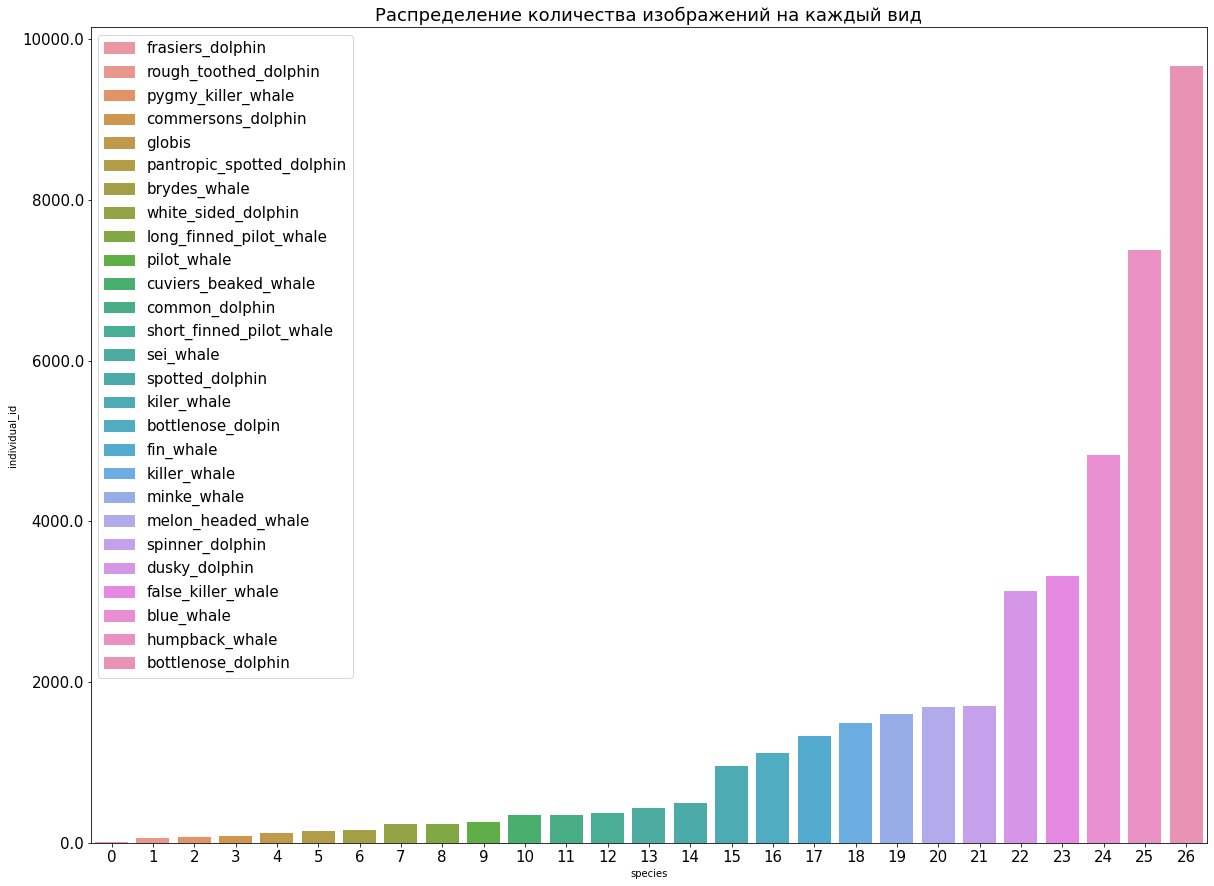

In [2]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
import matplotlib

import seaborn as sns

fig, ax1 = plt.subplots(figsize=(20,15))
plot = sns.barplot(x='species', y='individual_id', 
            data=df.groupby('species')['individual_id'].count().reset_index().sort_values(by='individual_id'),
                  ax=ax1)




bars = [r for r in ax1.get_children() if type(r)==Rectangle]
colors = [c.get_facecolor() for c in bars[:-1]]
patches = [matplotlib.patches.Patch(color=colors[i], label=t)
           for i,t in enumerate(t.get_text() for t in plot.get_xticklabels())]

plot.set_xticklabels(plot.get_xticks(), size=15)
plot.set_yticklabels(plot.get_yticks(), size=15)
plt.legend(handles=patches, loc="upper left", prop={'size': 15})

plot.set_title('Распределение количества изображений на каждый вид', fontsize=18);


Число individual_id представленных одним изображением в выборке: 8635
Число individual_id представленных менее 5 изображениями в выборке: 12610


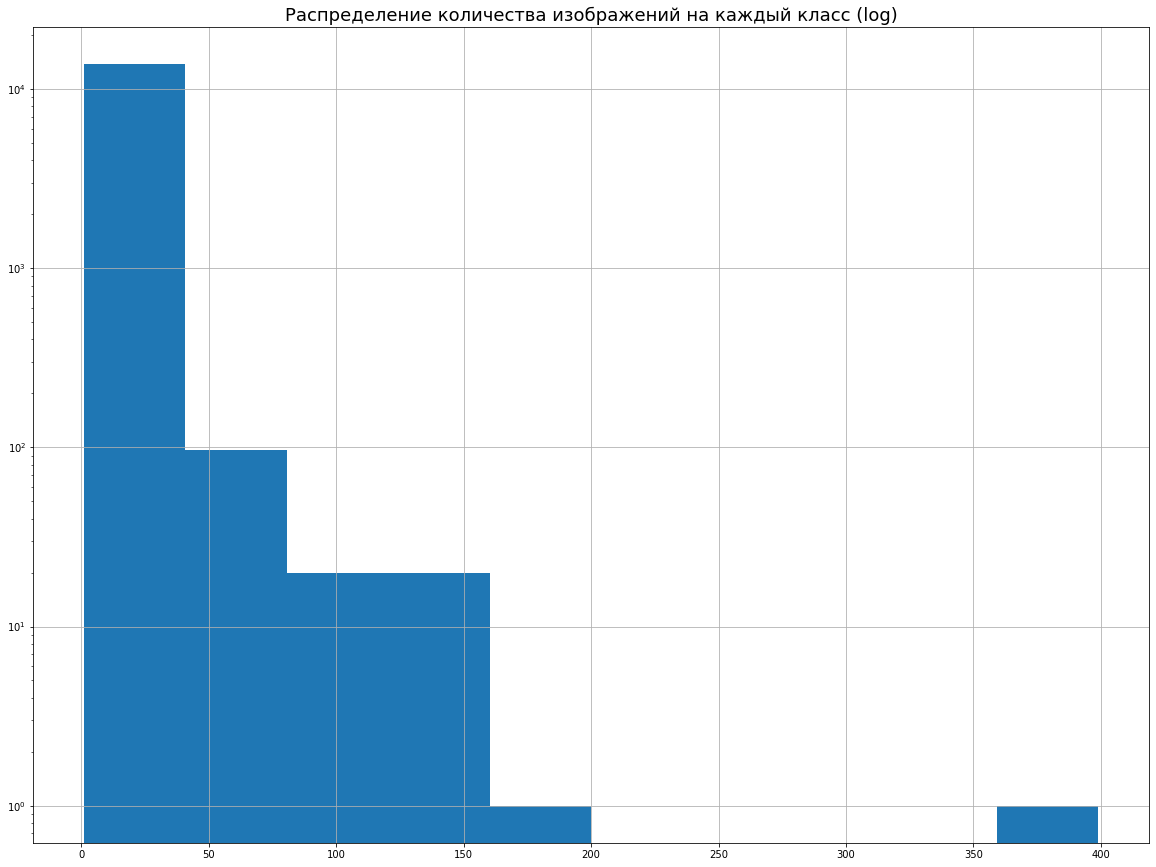

In [3]:
import numpy as np

fig, ax = plt.subplots(figsize=(20,15))



individual_id_counts = df.groupby('individual_id')['species'].count().reset_index().species.values

df.groupby('individual_id')['species'].count().reset_index().hist(log=True, ax=ax)
ax.set_title('Распределение количества изображений на каждый класс (log)', fontsize=18);


print('Число individual_id представленных одним изображением в выборке:', np.sum(individual_id_counts == 1))
print('Число individual_id представленных менее 5 изображениями в выборке:', np.sum(individual_id_counts < 5))


    Большинство классов (12610) в выборке представлено менее 5 примерами изображений, также множество классов (8635) представленно лишь одним изображением. 
    Таким образом задача относится к Few-Shot-Learning.

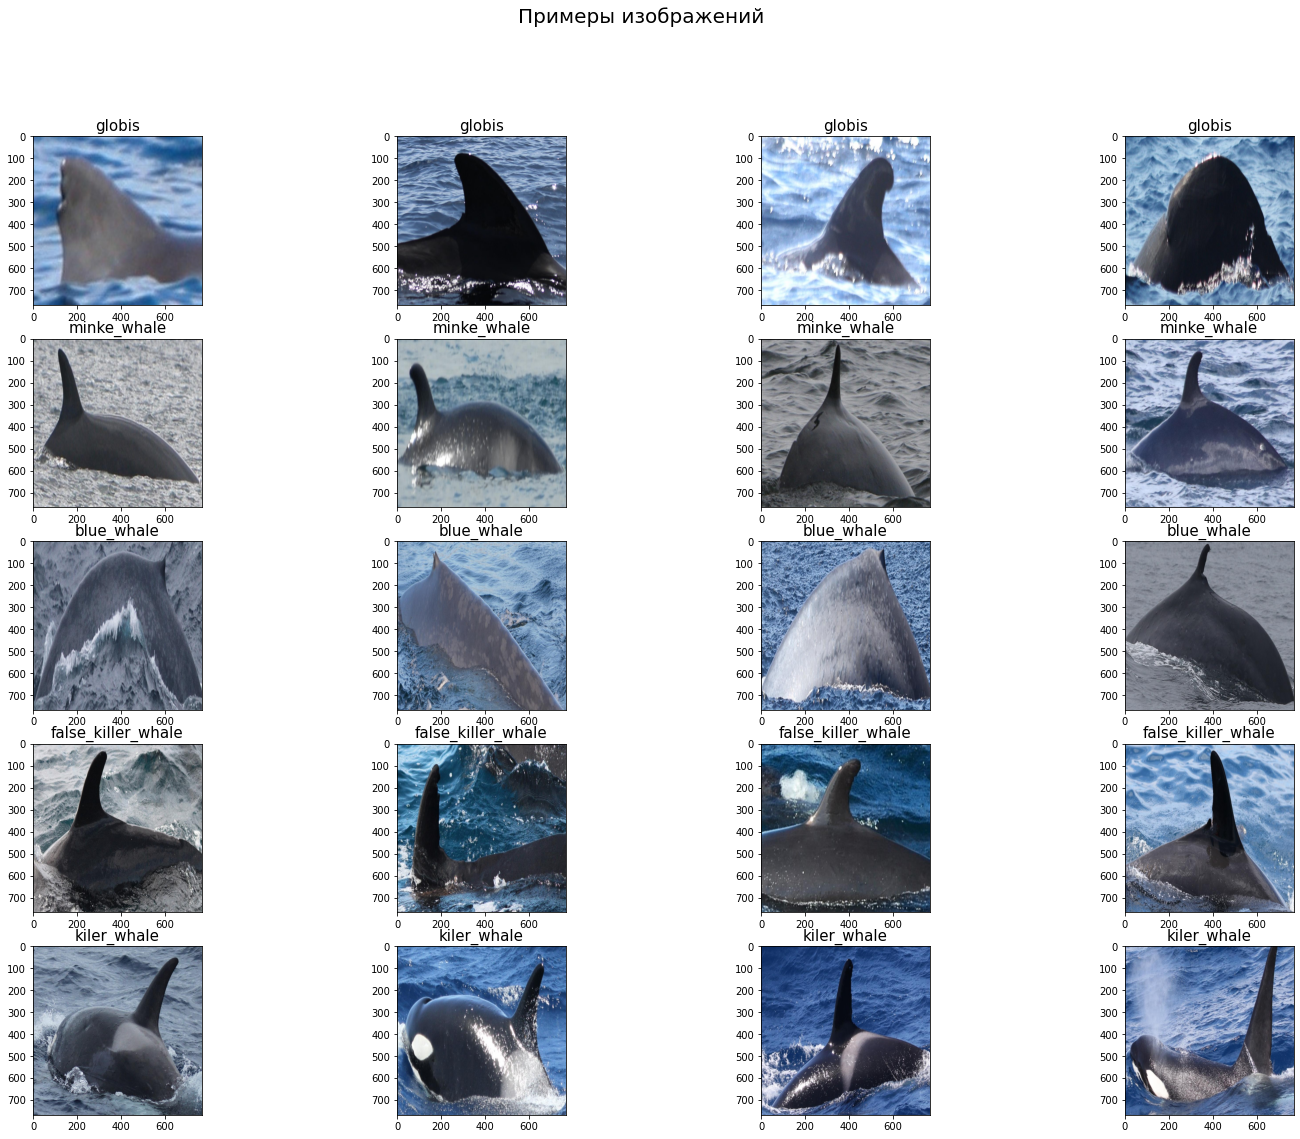

In [4]:
import numpy as np
import os

from PIL import Image

data_folder = './data/Train/'

species = np.random.choice(df.species.unique(), size=5, replace=False)

fig, axes = plt.subplots(5, 4)
fig.set_size_inches(25, 18)


fig.suptitle('Примеры изображений', fontsize=20)

for ax_row, spec in zip(axes, species):
    images = [os.path.join(data_folder, img_name) 
              for img_name in np.random.choice(df[df.species == spec].image.values, size=4, replace=False)]
    for ax, img_path in zip(ax_row, images):
        img = Image.open(img_path)
        ax.imshow(np.array(img))
        ax.set_title(spec, fontsize=15)
    
    

### Конфигурация

In [5]:
## Конфигурация модели
!cat 'src/configs/model_configs/dolgnet_model_config.yml'

model_name: 'dolgnet'
model_save_path: '../../model_weights'
model_save_name: 'tf_efficientnet_b5_dolgnet_v1'
model_parameters:
  emb_size: 512
  thresh: 0.5
  weights: ''
  gpus: [0, 1, 2, 3, 4, 5]
  dolgnet_parameters:
    input_dim: 3
    hidden_dim: 2048
    output_dim: 512
    scale: 15
    margin: 0.5
    backbone_name: 'tf_efficientnet_b5'
    local_branch_input_dim: 176
    fc_1_input_dim: 512
    drop_rate: 0
    img_size: 512

<img src="files/EfficientDolgNet.png">

    Для решения используем модель Dolg-EfficientNet.

    Для задач Few-Shot-Learning в качестве выходного слоя модели можно использовать ArcMarginProduct, который позволит обучить модель разделять большое количество классов с небольшим количеством примеров на класс.

In [ ]:
## Конфигурация параметров обучения
!cat 'src/configs/train_configs/happy_whale_train_config.yml'

In [ ]:
## Конфигурация данных
!cat 'src/configs/data_configs/happy_whale_data_config.yaml'

### Обучение

In [ ]:
## Запускаем обучение с выбранной конфигурацией
from src.train.train import run_train
import os

os.chdir('src/train')

run_train()

In [ ]:
## Результаты обучения модели
!cat ../../logs/tf_efficientnet_b5_dolgnet_v1.txt

    Итоговые результаты на тестовой выборке: MAP@5=71.7%